### Octavio Revetria 232745

# Práctico VAE (Variational AutoEncoders)

El objetivo de este práctico es explorar las Variational Autoencoders tanto en su implementación como sus bases teóricas.

In [126]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torchinfo
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

### Dataset

In [127]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

Running on cuda


In [128]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [129]:
batch_images[0].shape

torch.Size([128, 1, 28, 28])

In [130]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1*28*28).to(DEVICE)
flatten_batch.shape

torch.Size([128, 784])

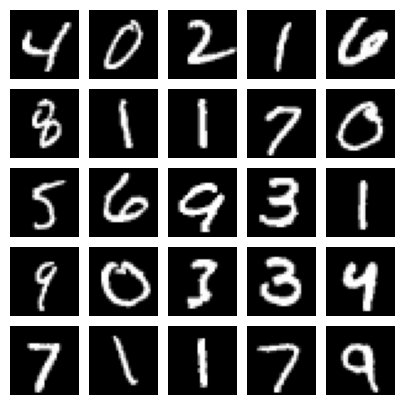

In [131]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

### Modelo VAE

In [132]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=200, latent_dim=2, device='cpu'):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        self.device = device

        # TODO: Completar esta sección. Definir las capas de la VAE.
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  
        )

    def encode(self, x):
        # TODO: Completar esta sección. Debes codificar 'x' usando la capa encoder
        # computar la media y la varianza de la distribución latente.
        # Devuelve la media y varianza
        x_encoded = self.encoder(x)
        mean = self.mean_layer(x_encoded)
        logvar = self.logvar_layer(x_encoded)
        return mean, logvar

    def reparameterization(self, mean, var):
        # TODO: Completar esta sección. Aplica el truco de reparametrización.
        # Devuelve 'z' luego de hacer el reparametrization trick.
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        # TODO: Completar esta sección. Usar el decodificador para transformar 'z' 
        #      de nuevo a una representación del espacio original.
        # Devuelve la reconstrucción.
        x_decoded = self.decoder(z)
        return x_decoded

    def forward(self, x):
        # TODO: Completar esta sección. Sigue el flujo de la VAE:
        # 1. Codificar
        # 2. Reparametrizar
        # 3. Decodificar
        # Devuelve la reconstrucción, la media y la varianza.
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, logvar
    
    def generate(self, num_samples=1):
        # TODO: Completar esta sección. Generar nuevas muestras a partir de la distribución latente.
        # Devuelve las nuevas muestras generadas.
        z = torch.randn(num_samples, self.latent_dim).to(self.device)
        samples = self.decode(z)
        return samples

In [133]:
LR = 1e-3

model = VAE(device=DEVICE).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [134]:
torchinfo.summary(model, input_size=(100,784), col_names = ('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                --
├─Sequential: 1-1                        [100, 784]                [100, 400]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─ReLU: 2-2                         [100, 400]                [100, 400]                --
├─Linear: 1-2                            [100, 400]                [100, 2]                  802
├─Linear: 1-3                            [100, 400]                [100, 2]                  802
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-3                       [100, 2]                  [100, 400]                1,200
│    └─ReLU: 2-4                         [100, 400]                [100, 400]                --
│    └─Linear: 2-5       

###  Función de Pérdida

In [135]:
def loss_function(x, x_hat, mean, log_var):
    # TODO: Completar esta sección. Implementar la función de pérdida de la VAE.
    # 1) Calcule la pérdida de reconstrucción (reconstruction loss) entre x y x_hat.
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # 2) Calcule la divergencia KL (Kullback-Leibler divergence) entre la distribución latente y una distribución normal estándar.
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # 3) Devuelva la pérdida.
    return reproduction_loss + KLD

### Entrenamiento

In [136]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), -1).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()
        if (epoch + 1) % 2 == 0:
            print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [137]:
train(model.to(DEVICE), optimizer, epochs=10, device=DEVICE)

	Epoch 2 	Average Loss:  167.14797649220523
	Epoch 4 	Average Loss:  161.2179197001661
	Epoch 6 	Average Loss:  158.07022076794226
	Epoch 8 	Average Loss:  156.11345315590884
	Epoch 10 	Average Loss:  154.76268786242883


9270904.053710938

### Generación

In [138]:
def generate_digit(model, N = 25, z_dim=2):
    x_decoded = model.generate(num_samples=N).to(DEVICE)
    digits = x_decoded.detach().cpu().reshape(N, 28, 28)

    cols = 5
    rows = (N + cols - 1) // cols  
    
    fig, ejes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    ejes = ejes.flatten() 
    
    for i in range(N):
        ejes[i].imshow(digits[i], cmap='gray')
        ejes[i].axis('off')
    
    for j in range(N, rows*cols):
        ejes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

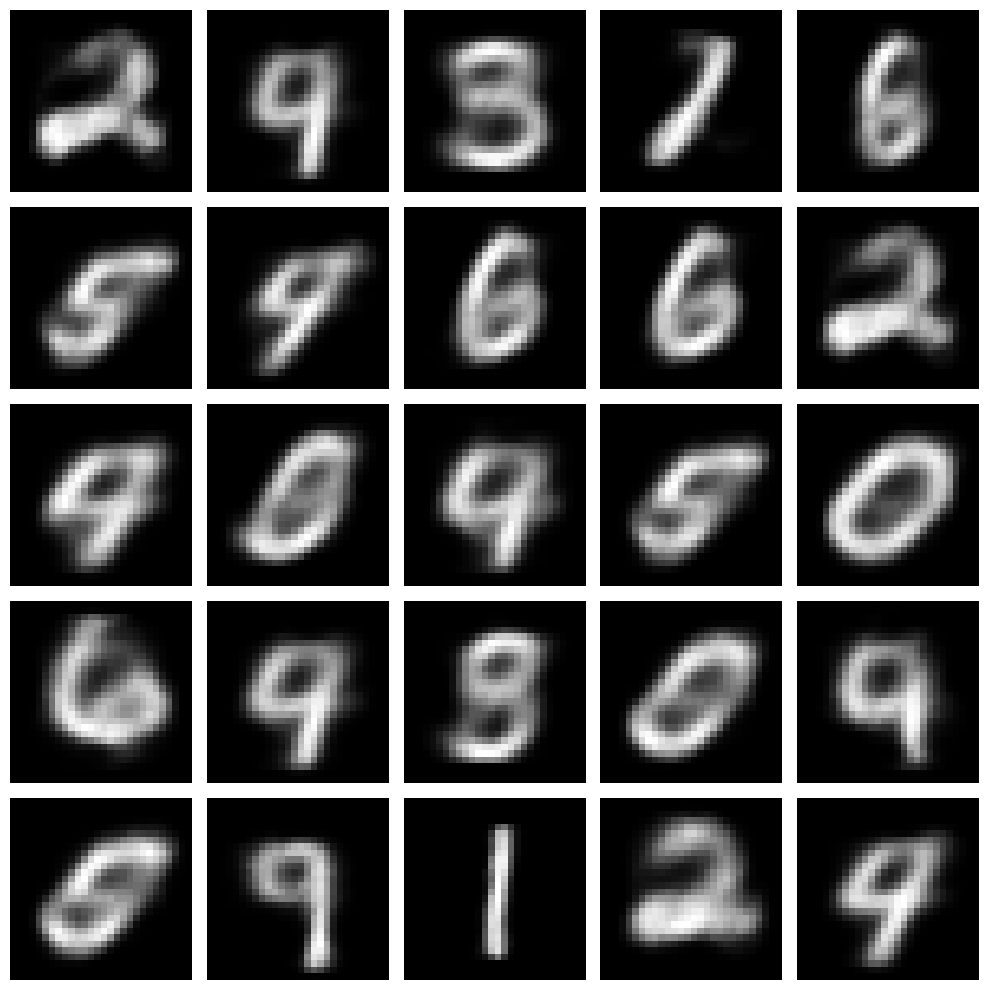

In [139]:
generate_digit(model = model, z_dim = model.latent_dim, N=25)

### Mostrar el espacio latente

In [140]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

C:\Users\Octav\AppData\Local\Temp\ipykernel_4716\2141494282.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


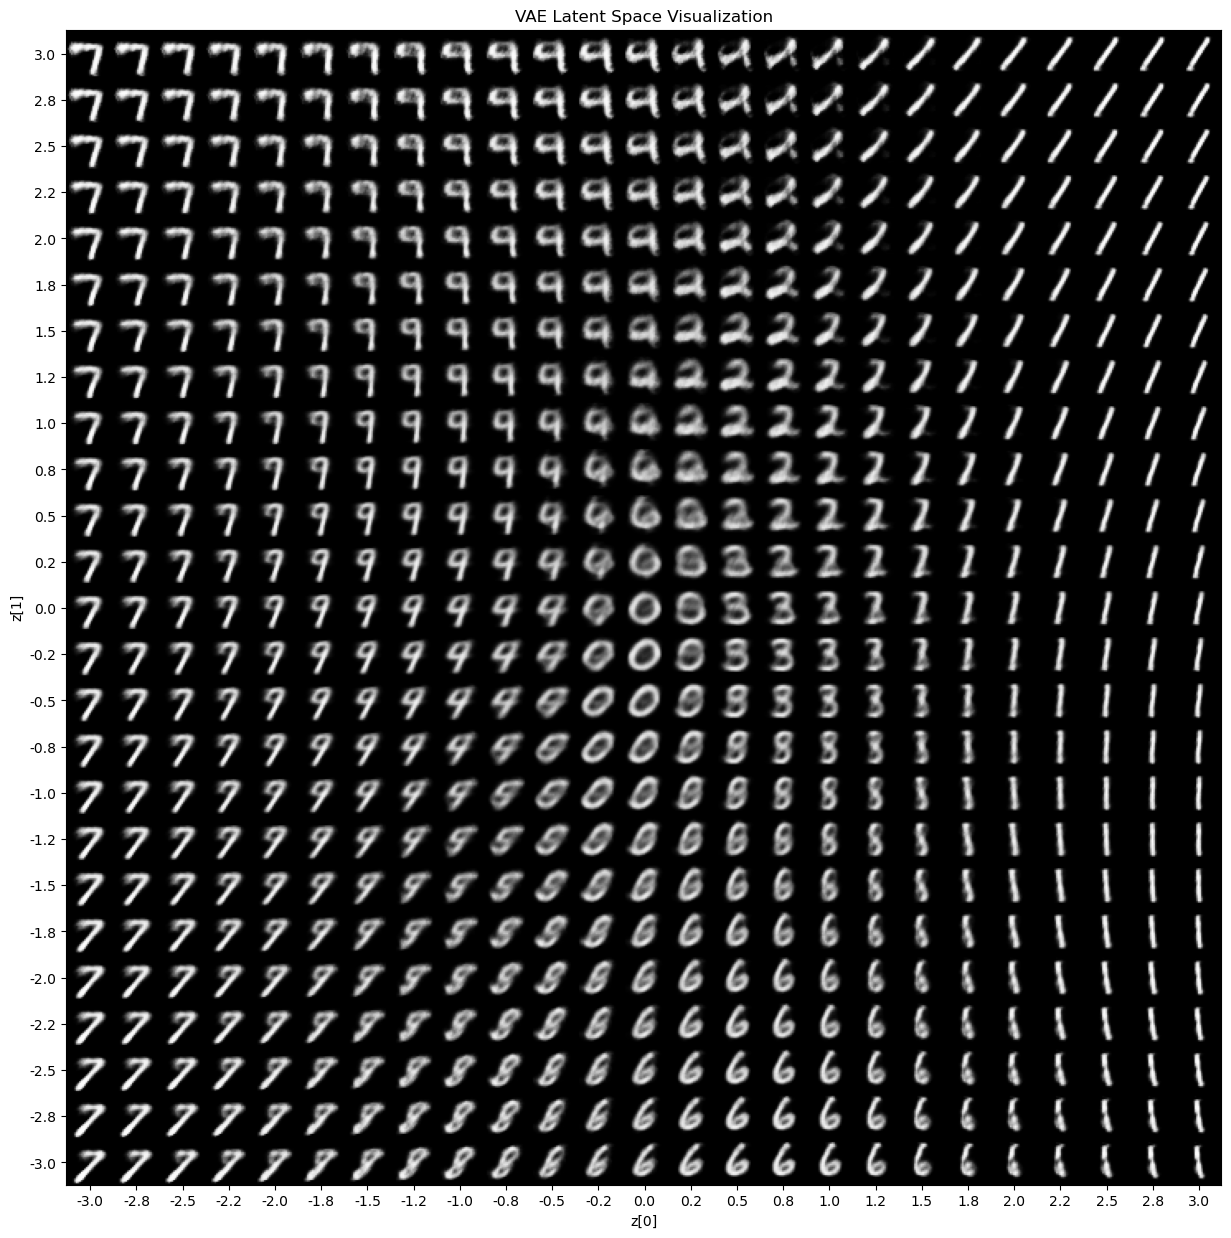

In [141]:
plot_latent_space(model, scale=3.0)

## Ejercicios

1. Complete el código.
2. ¿Por qué es necesario el truco de reparametrización en las VAE?
3. ¿Qué representan las variables mean y var en la VAE?
4. Cree y entrene nuevas VAE modificando los hiperparámetros.
5. ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?
6. ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?
7. Explique que ve en la imágen que se genera cuando llamamos a la función `plot_latent_space`. Si cambiamos la dimensión del espacio latente, ¿qué pasaría con esta gráfica?

### *Respuestas*

#### Pregunta 2:
Para separar el ruido aleatorio, de los parametros que definen la distribucion de Z, que calculamos. De ese modo el modelo puede ajustar los parametros calculados, a pesar de que haya un muestreo aleatorio.
Es necesario separarlos, porque no podemos realizar backpropagation en la componente aleatoria. En los parametros calculados si.
Al separarlos se puede derivar solo parte empirica y por lo tanto usar backpropagation para ajustar los parametros de la distribucion normal de Z.

#### Pregunta 3:
**mean:** Marca el promedio de una distribucion, si todos los valores fueran iguales, tendrian ese valor.

**var:** Marca que tan dispersos pueden estar los valores de la distribucion con respecto al valor promedio.

Aplicado a una distribucion normal, nos marca en el pico de mayor concentracion de datos de la distribucion. Mientras que la desviacion nos marca, el ancho de ese pico.

En el caso de las VAE, se codifican cada una de las imagenes, para calcular media y varianza para describir su distribucion normal. Y luego muestreando una variable aleatoria se generan nuevas imagenes siguiendo la distribucion descripta con su media y varianza en el espacio latente de la muestra.

### *Ejercicio 4*

In [142]:
params_list = [
    {"hidden_dim": 600, "latent_dim": 2, "LR": 1e-3, "epochs": 10},
    {"hidden_dim": 400, "latent_dim": 5, "LR": 1e-3, "epochs": 20},
    {"hidden_dim": 400, "latent_dim": 10, "LR": 1e-3, "epochs": 30},
]

In [143]:
for i, params in enumerate(params_list):
    print(f"Modelo {i+1}")
    
    model = VAE(
        input_dim=784,
        hidden_dim=params["hidden_dim"],
        latent_dim=params["latent_dim"],
        device=DEVICE
    ).to(DEVICE)
    
    optimizer = Adam(model.parameters(), lr=params["LR"])
    train(model, optimizer, epochs=params["epochs"], device=DEVICE)
    
    torch.save(model.state_dict(), f"vae_model_{i+1}.pt") #Guardo modelo entrenado


Modelo 1
	Epoch 2 	Average Loss:  165.58763911581448
	Epoch 4 	Average Loss:  161.07468207269653
	Epoch 6 	Average Loss:  158.5037029461983
	Epoch 8 	Average Loss:  156.4592081053644
	Epoch 10 	Average Loss:  154.86216977111295
Modelo 2
	Epoch 2 	Average Loss:  139.57624842977933
	Epoch 4 	Average Loss:  133.14813613891602
	Epoch 6 	Average Loss:  130.1586277464516
	Epoch 8 	Average Loss:  128.18182389349
	Epoch 10 	Average Loss:  126.72615765302609
	Epoch 12 	Average Loss:  125.66962956159543
	Epoch 14 	Average Loss:  124.79948955112033
	Epoch 16 	Average Loss:  124.10415618440025
	Epoch 18 	Average Loss:  123.491636651194
	Epoch 20 	Average Loss:  122.96118087442512
Modelo 3
	Epoch 2 	Average Loss:  125.29529490022578
	Epoch 4 	Average Loss:  117.29860881251147
	Epoch 6 	Average Loss:  114.32217519711226
	Epoch 8 	Average Loss:  112.61932110582661
	Epoch 10 	Average Loss:  111.39461466797397
	Epoch 12 	Average Loss:  110.47787767393976
	Epoch 14 	Average Loss:  109.66382566272704
	Ep

In [144]:
model_3.latent_dim

10

In [150]:
model_3 = VAE(latent_dim=10, device=DEVICE).to(DEVICE)
model_3.load_state_dict(torch.load("vae_model_3.pt"))

<All keys matched successfully>

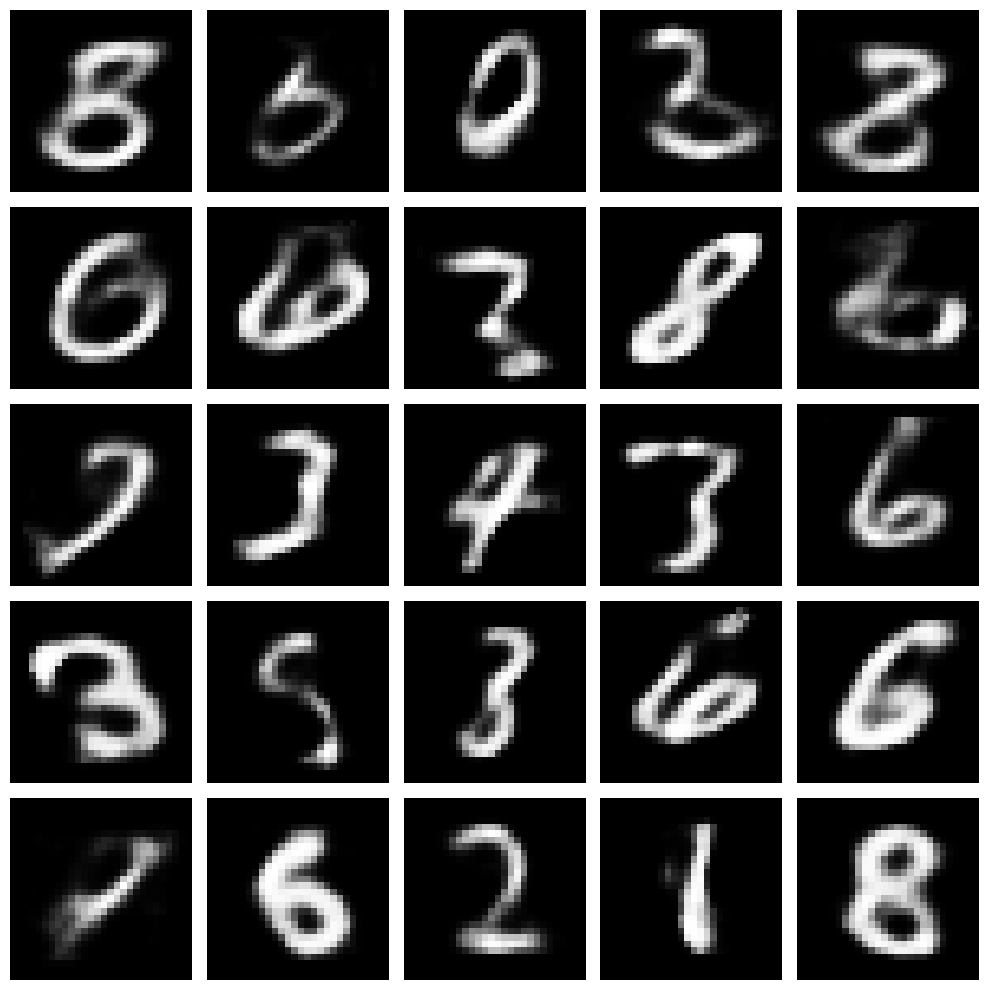

In [151]:
generate_digit(model_3, z_dim = model_3.latent_dim, N=25)

### *Pregunta 5*
En los hiperparametros probados, a medida que aumentamos las dimensiones del espacio latente, aumenta el rendimiento del modelo.

Dando a entender, que con 2 dimensiones, no se logra captar todas los detalles y patrones de los datos. Cuando se aumenta la dimension a 10, los resultados mejoran considerablemente.

A su vez, a medida que aumentamos las dimensiones, corremos el riesgo que el modelo se adjuste en demasiado a los datos y termine memorizandolos. Perdiendo asi capacidad de generalizacion.

Como en otros modelos, es importante no sobreajustar.

### *Pregunta 6*
La regularizacion KL indica que tan alejados estamos de una distribucion normal. Cuanto mas cercana a 0 la KL, mas parecida es a la distribucion normal. Por otro lado, cuanto mas lejana, mas se acerca la KL a 1.

De esta manera buscamos minimizar la KL en nuestra funcion de perdida, porque queremos que se parezca lo mas posible a una normal.

Ya que una distribucion normal, comprende una representacion compacta y que permite generar nuevas muestras de partir de los parametros latentes.

### *Pregunta 7*
Nos marca las imagenes que se decodifican a partir de los puntos del espacio latente. 

Es decir, si tenemos un espacio latente de dimensión 2, por ejemplo con valores que van de min (-1.3,0.1) hasta max (0.5,1.7), se genera un eje horizontal que va de -1.3 a 0.5 y un eje vertical que va de 0.1 a 1.7.

En este plano se colocan las imagenes generadas a partir de los distintos puntos del espacio latente. Las transiciones entre imagenes se suavizan, permitiendo visualizar como cambian progresivamente las imagenes decodificadas segun su posición en el espacio latente.

Si cambiamos la dimension a algo mayor de 2, no podemos visualizarlo con una grilla de manera directa. Por que la dimensionalidad, no lo permite.